# Code Assignment 17 — K-Means Model Comparison with CH & DB + Assumption Testing (Mall Customers)

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:**  Compare **two feature sets** for K-Means at the **same K**:  
- **Model 1:** 2 features → `['Annual Income (k$)', 'Spending Score (1-100)']`  
- **Model 2:** 3 features → `['Age', 'Annual Income (k$)', 'Spending Score (1-100)']`  
Evaluate with **Silhouette (↑), Calinski–Harabasz (↑), Davies–Bouldin (↓)**, **separation ratio** (↑), **cluster sizes**, and **stability (median ARI) (↑)**.



## Instructor Guidance (Pseudocode + Docs)

**Docs**  
- `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
- `KMeans`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
- `silhouette_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html  
- `calinski_harabasz_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html  
- `davies_bouldin_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html  
- `adjusted_rand_score` (stability): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

### Pseudocode Plan (Model Comparison)
  1) Load CSV → pick clean numeric columns (2D vs 3D).  
  2) **Scale** each feature set **separately** with `StandardScaler`.  
  3) Fix **K** (e.g., K=4).  
  4) Fit KMeans on each set → get labels & centers.  
  5) Compute metrics: `silhouette_score` (↑), `calinski_harabasz_score` (↑), `davies_bouldin_score` (↓).  
  6) Assumption checks: **separation ratio** (min between-centroid distance ÷ max within-cluster spread), **cluster sizes** (%), **stability via ARI** across seeds.  
  7) Compare models in a table → pick one and justify.


## Your Task — Step-by-Step
Work in pairs. Keep it minimal and clear.

### 0) Run Helper Functions and do your Imports

In [1]:
# RUN THIS CELL WITHOUT CHANGES 

def cluster_size_pct(labels):
    """Return % size of each cluster (sorted by cluster index)."""
    s = pd.Series(labels).value_counts(normalize=True).sort_index()
    return (s * 100).round(1)

def within_between_ratio(Z, labels, centers):
    """
    Heuristic separation metric:
    min distance among centroids ÷ max within-cluster spread (avg feature std per cluster).
    Higher is better (more separated vs within spread).
    """
    within = []
    for c in range(centers.shape[0]):
        pts = Z[labels == c]
        if len(pts) == 0:
            within.append(np.nan)
        else:
            within.append(pts.std(axis=0).mean())
    within = np.array(within, dtype=float)
    max_within = np.nanmax(within)

    D = cdist(centers, centers)  # centroid distance matrix
    np.fill_diagonal(D, np.nan)
    min_between = np.nanmin(D)
    return float(min_between / max_within)

def stability_ari(Z, k, seeds=(0, 1, 2, 3, 4)):
    """
    Fit KMeans across multiple seeds and compute median Adjusted Rand Index across pairs.
    Higher median ARI = more stable clustering to initialization.
    """
    label_sets = []
    for s in seeds:
        km = KMeans(n_clusters=k, n_init=10, random_state=s).fit(Z)
        label_sets.append(km.labels_)
    pairs = [(i, j) for i in range(len(label_sets)) for j in range(i+1, len(label_sets))]
    aris = [adjusted_rand_score(label_sets[i], label_sets[j]) for (i, j) in pairs]
    return float(np.median(aris))


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### 1) Load the Mall Customers CSV & Preview
Use the same dataset as last time.

In [3]:
df = pd.read_csv("/Users/kabbo/Downloads/Mall_customers copy.csv", low_memory=False)

### 2) Build 2D and 3D feature sets (numeric only, minimal cleaning)

- 2D set:  Annual Income and Spending Score
- 3D set:  Age, Annual Income, Spending Score 

**Be sure to scale!**


In [4]:
# Define your feature subsets
X2 = df[["Age", "Spending Score (1-100)"]].values
X3 = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].values

# Scale each feature set independently
scaler_2 = StandardScaler()
Z2 = scaler_2.fit_transform(X2)

scaler_3 = StandardScaler()
Z3 = scaler_3.fit_transform(X3)

print("Z2 shape:", Z2.shape)
print("Z3 shape:", Z3.shape)


Z2 shape: (200, 2)
Z3 shape: (200, 3)


### 3) Choose a single k for BOTH models (you can try 3, 4, 5, etc.)

In [7]:
K_FIXED = 4
print('Using K =', K_FIXED)


Using K = 4


### 4) Fit Model 1 (2D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!


In [10]:
print("MODEL 1 (2D) RESULTS\n")

# Fit KMeans
km2 = KMeans(n_clusters=K_FIXED, n_init=10, random_state=42)
labels2 = km2.fit_predict(Z2)
centers2 = km2.cluster_centers_

# Metrics
sil = silhouette_score(Z2, labels2)
ch  = calinski_harabasz_score(Z2, labels2)
db  = davies_bouldin_score(Z2, labels2)
sep = within_between_ratio(Z2, labels2, centers2)
stab = stability_ari(Z2, K_FIXED)

print(f"Silhouette Score:           {sil:.4f}")
print(f"Calinski-Harabasz Score:    {ch:.2f}")
print(f"Davies-Bouldin Score:       {db:.4f} (lower better)")
print(f"Separation Ratio:           {sep:.4f} (higher better)")
print(f"Stability (Median ARI):     {stab:.4f}")
print("\nCluster Size %:")
print(cluster_size_pct(labels2))

MODEL 1 (2D) RESULTS

Silhouette Score:           0.4384
Calinski-Harabasz Score:    225.80
Davies-Bouldin Score:       0.8244 (lower better)
Separation Ratio:           2.6427 (higher better)
Stability (Median ARI):     1.0000

Cluster Size %:
0   25.0000
1   32.5000
2   19.0000
3   23.5000
Name: proportion, dtype: float64


### 5) Fit Model 2 (3D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!
- Use same k as Model 1

In [11]:
print("MODEL 2 (3D) RESULTS\n")

# Fit KMeans on 3D features
km3 = KMeans(n_clusters=K_FIXED, n_init=10, random_state=0).fit(Z3)
labels3 = km3.labels_
centers3 = km3.cluster_centers_

# Compute metrics
sil_3 = silhouette_score(Z3, labels3)
ch_3 = calinski_harabasz_score(Z3, labels3)
db_3 = davies_bouldin_score(Z3, labels3)
sep_3 = within_between_ratio(Z3, labels3, centers3)
stab_3 = stability_ari(Z3, K_FIXED)

print(f"Silhouette Score:           {sil_3:.4f}")
print(f"Calinski-Harabasz Score:    {ch_3:.2f}")
print(f"Davies-Bouldin Score:       {db_3:.4f} (lower better)")
print(f"Separation Ratio:           {sep_3:.4f} (higher better)")
print(f"Stability (Median ARI):     {stab_3:.4f}")

print("\nCluster Size %:")
print(cluster_size_pct(labels3))


MODEL 2 (3D) RESULTS

Silhouette Score:           0.4040
Calinski-Harabasz Score:    125.68
Davies-Bouldin Score:       0.9308 (lower better)
Separation Ratio:           3.1974 (higher better)
Stability (Median ARI):     1.0000

Cluster Size %:
0   19.0000
1   28.5000
2   32.5000
3   20.0000
Name: proportion, dtype: float64


### 6) Visualize Model 1 (2D Scatter Plot)


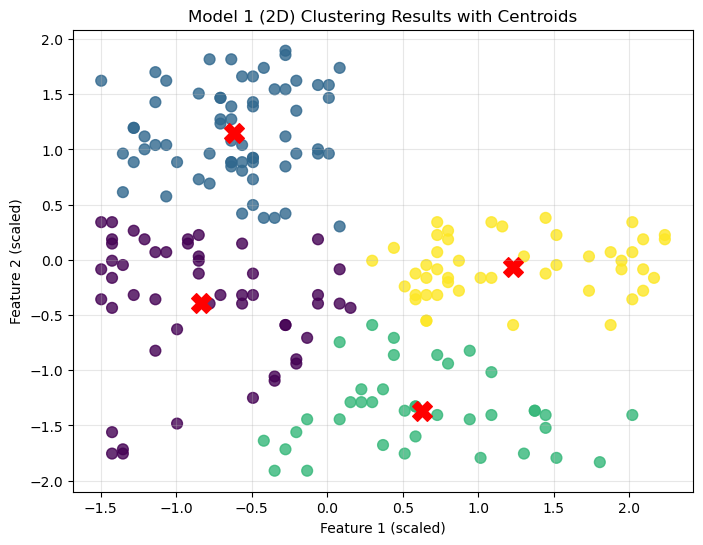

In [13]:
plt.figure(figsize=(8,6))

plt.scatter(
    Z2[:, 0], Z2[:, 1],
    c=labels2,
    s=60,
    alpha=0.8
)

# Plot centers in red
plt.scatter(
    km2.cluster_centers_[:, 0],
    km2.cluster_centers_[:, 1],
    c='red',
    s=200,
    marker='X'
)

plt.title("Model 1 (2D) Clustering Results with Centroids")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.grid(alpha=0.3)

plt.show()


## We Share — Reflection (short, specific)
1) **Which model is better and why?** Reference **Sil (↑), CH (↑), DB (↓)**, **separation ratio (↑)**, **stability ARI (↑)**, and **cluster sizes**.  

2) **Assumptions & ethics:** Did your chosen model show **non-overlapping, roughly spherical, similarly dense** clusters? If not, what risk could that pose to stakeholders (mis-targeted offers, unfair treatment)?  
3) **Next step:** If you had to ship this, what monitoring would you add (e.g., re-check metrics quarterly, watch for tiny cluster drift, re-scale after schema changes)?

> Tip: If metrics conflict (e.g., CH prefers K=6, DB prefers K=4), prefer **parsimonious K** with **clear separation**, **stable labels**, and **business actionability**.


### **1) Which model is better and why?**

Between the 2D and 3D models (both at K = 4), It seems **Model 1 (2D)** is the better clustering model overall.

* **Silhouette Score:** 2D is **higher** (0.4384 vs. 0.4040) → better-defined clusters.
* **Calinski–Harabasz:** 2D is **higher** (225.80 vs. 125.68) → tighter clusters and stronger separation.
* **Davies–Bouldin:** 2D is **lower** (0.8244 vs. 0.9308) → less overlap between clusters.
* **Separation Ratio:** 3D is higher (3.1974 vs. 2.6427), but this is **only one metric**, and all the core metrics disagree so I would treat this as an outlier.
* **Stability (ARI):** Both are perfectly stable (1.00).
* **Cluster Sizes:** Both are balanced, but 2D is slightly more even.

Because **three major metrics agree** (Sil ↑, CH ↑, DB ↓), Model 1 is the **more reliable** and **actionable** clustering solution.

### **2) Assumptions & Ethics**

K-means assumes clusters are **spherical, evenly sized, and well separated**.
Model 1’s 2D scatterplot showed **mostly separated clusters**, but not perfectly spherical.

**The risks if assumptions fail:**

* Customers near cluster boundaries could be **misclassified**, leading to misleading marketing segmentation.
* Stakeholders could make **biased decisions**, especially if uneven cluster density hides important minority behaviors.
* Overly granular or poorly separated clusters may cause unfair or irrelevant targeting (e.g., high-spending customers lumped with low-spending ones).


### **3) Next Steps**

If I had to deploy this model:

* **Monitor cluster size balance** — unusually small clusters may signal noise or pipeline issues.
* **Re-standardize features** if the schema changes or new data sources appear.
* **Collect feedback** (campaign performance, targeting accuracy) to validate that clusters are behaving as intended.

